<a href="https://colab.research.google.com/github/PiotMik/quantutils/blob/feature%2Fmilstein/examples/Convergence_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install git+https://github.com/PiotMik/quantutils.git@feature/milstein

  Cloning https://github.com/PiotMik/quantutils.git (to revision feature/milstein) to /tmp/pip-req-build-dn06g699
  Running command git clone -q https://github.com/PiotMik/quantutils.git /tmp/pip-req-build-dn06g699
  Running command git checkout -b feature/milstein --track origin/feature/milstein
  Switched to a new branch 'feature/milstein'
  Branch 'feature/milstein' set up to track remote branch 'feature/milstein' from 'origin'.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from typing import Optional, Callable
import numpy as np
sns.set()

In [33]:
def milstein(x0: float, a_t: Callable, b_t: Callable,
             n_steps: int, n_paths: int, dt: float,
             bx_t: Optional[Callable] = None,
             rnorm: Optional[np.ndarray] = None):

    if bx_t is None:
        bx_t = lambda t, x: (b_t(t, x + dt) - b_t(t, x))/dt

    if rnorm is None:
        rnorm = np.random.normal(size=(n_steps - 1, n_paths))

    t = np.zeros(shape=(n_steps,))
    St = np.zeros(shape=(n_steps, n_paths))
    St[0, :] = x0

    for i, Z in enumerate(rnorm):
        St[i + 1,] = St[i,] + a_t(t[i], St[i,]) * dt + b_t(t[i], St[i,]) * Z * np.sqrt(dt) + \
                     bx_t(t[i], St[i,]) * b_t(t[i], St[i,]) * 0.5 * ((Z * np.sqrt(dt)) ** 2 - dt)
        t[i + 1] = t[i] + dt

    return t, St

def euler_maruyama(x0: float, a_t: Callable, b_t: Callable,
                   n_steps: int, n_paths: int, dt: float,
                   rnorm: Optional[np.ndarray] = None):

    if rnorm is None:
        rnorm = np.random.normal(size=(n_steps - 1, n_paths))

    t = np.zeros(shape=(n_steps,))
    St = np.zeros(shape=(n_steps, n_paths))
    St[0, :] = x0

    for i, Z in enumerate(rnorm):
        St[i + 1,] = St[i,] + a_t(t[i], St[i,]) * dt + b_t(t[i], St[i,]) * Z * np.sqrt(dt)
        t[i + 1] = t[i] + dt

    return t, St

def exact_gbm(x0: float, mu:float, sigma: float,
              n_steps: int, n_paths: int, dt: float,
              rnorm: Optional[np.ndarray] = None):

    if rnorm is None:
        rnorm = np.random.normal(size=(n_steps - 1, n_paths))

    t = np.zeros(shape=(n_steps,))
    St = np.zeros(shape=(n_steps, n_paths))
    St[0, :] = x0

    for i, Z in enumerate(rnorm):
        St[i + 1,] = St[i,] * np.exp((mu - 0.5*sigma**2)*dt + sigma * Z * np.sqrt(dt))
        t[i + 1] = t[i] + dt

    return t, St

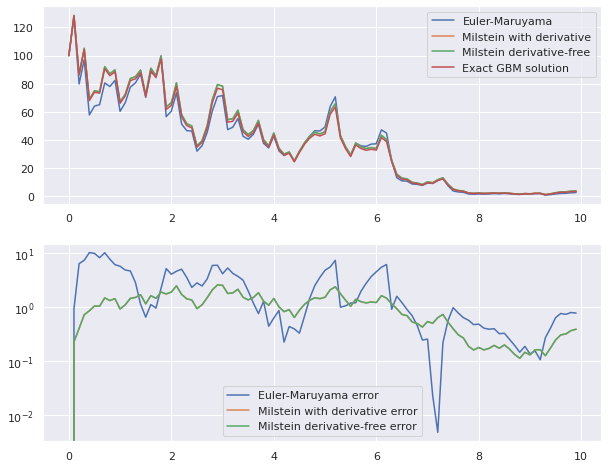

In [56]:
x0 = 100.
mu = .05
sigma = .7
a_t = lambda t, x: x * mu
b_t = lambda t, x: x * sigma
bx_t = lambda t, x: sigma

n_steps = 100
n_paths = 1
T = 10.

rnorm = np.random.normal(size=(n_steps - 1, n_paths))

t, St_eul = euler_maruyama(x0=x0, 
                           n_steps = n_steps, n_paths=n_paths,
                           a_t = a_t, b_t = b_t, dt = T/n_steps,
                           rnorm=rnorm)
t, St_mil = milstein(x0=x0, 
                     n_steps = n_steps, n_paths=n_paths,
                     a_t = a_t, b_t = b_t, bx_t = bx_t,
                     dt = T/n_steps, rnorm=rnorm)
t, St_mil_df = milstein(x0=x0, 
                        n_steps = n_steps, n_paths=n_paths,
                        a_t = a_t, b_t = b_t, dt = T/n_steps,
                        rnorm=rnorm)
t, St_exact = exact_gbm(x0=x0, 
                        n_steps = n_steps, n_paths=n_paths,
                        mu = mu, sigma = sigma, dt = T/n_steps,
                        rnorm=rnorm)

plt.rcParams['figure.figsize'] = (10, 8)
fig, ax = plt.subplots(2, 1)
ax[0].plot(t, St_eul, label = 'Euler-Maruyama')
ax[0].plot(t, St_mil, label = 'Milstein with derivative')
ax[0].plot(t, St_mil_df, label = 'Milstein derivative-free')
ax[0].plot(t, St_exact, label = 'Exact GBM solution')
ax[0].legend()

ax[1].plot(t, np.abs(St_eul - St_exact), label = 'Euler-Maruyama error')
ax[1].plot(t, np.abs(St_mil - St_exact), label = 'Milstein with derivative error')
ax[1].plot(t, np.abs(St_mil_df - St_exact), label = 'Milstein derivative-free error')
ax[1].legend()
ax[1].set_yscale('log')

In [80]:
def get_error(n_steps, error_metric: Callable):
  x0 = 100.
  mu = .05
  sigma = .7
  a_t = lambda t, x: x * mu
  b_t = lambda t, x: x * sigma
  bx_t = lambda t, x: sigma

  n_paths = 1
  T = 10.

  rnorm = np.random.normal(size=(n_steps - 1, n_paths))
  dt = T/n_steps

  t, St_eul = euler_maruyama(x0=x0, 
                            n_steps = n_steps, n_paths=n_paths,
                            a_t = a_t, b_t = b_t, dt = dt,
                            rnorm=rnorm)
  t, St_mil = milstein(x0=x0, 
                      n_steps = n_steps, n_paths=n_paths,
                      a_t = a_t, b_t = b_t, bx_t = bx_t,
                      dt = dt, rnorm=rnorm)
  t, St_mil_df = milstein(x0=x0, 
                          n_steps = n_steps, n_paths=n_paths,
                          a_t = a_t, b_t = b_t, dt = dt,
                          rnorm=rnorm)
  t, St_exact = exact_gbm(x0=x0, 
                          n_steps = n_steps, n_paths=n_paths,
                          mu = mu, sigma = sigma, dt = dt,
                          rnorm=rnorm)  
  df_errors = pd.DataFrame.from_dict({'EulMay': error_metric(St_exact, St_eul),
                                      'MilDer': error_metric(St_exact, St_mil),
                                      'MilDerFree': error_metric(St_exact, St_mil_df)},
                                     orient='index')
  df_errors['dt'] = dt
  df_errors.reset_index(inplace = True)
  df_errors.columns = ['Method', 'Error', 'dt']
  return df_errors

In [143]:
weak_error = lambda y_true, y_pred: np.abs((y_true[-1, :] - y_pred[-1, :]).mean())
n_steps = [2, 5, 10, 50, 100, 1000, 2000, 5000, 10000, 100000, 200000]

errs = [get_error(n_steps = i_steps, error_metric=weak_error) for i_steps in n_steps]
errs = pd.concat(errs).reset_index(drop=True)
errs['log(err)'] = np.log(errs['Error'])
errs['log(dt)'] = np.log(errs['dt'])

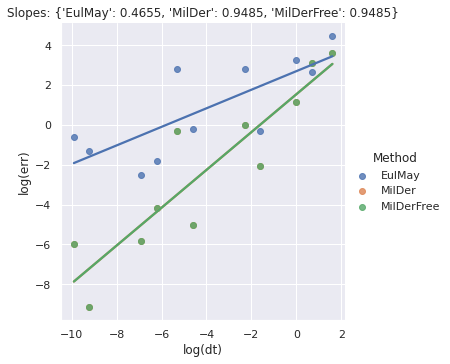

In [144]:
from sklearn.linear_model import LinearRegression

slopes = {}
for method in errs.Method.unique():
  lr = LinearRegression()
  subset = errs.query(f'Method == "{method}"')
  lr.fit(X = subset['log(dt)'].values.reshape(-1, 1), y=subset['log(err)'].values)
  slopes[method] = lr.coef_[0].round(4)
sns.lmplot(x='log(dt)', y='log(err)', data=errs, hue='Method', ci=False)
plt.title(f'Slopes: {slopes}');